# Welcome to the election ballot varifier!
Elections are high-stake. There is plenty of incentive to cheat. With this, I hope to find duplicate ballots.

### Dataset + Data Augmentation
The dataset is only a handful of ballot images, but they will be duplicated, and slightly rotated.

### Cluster
We'll be employing a series of machine learning techniques, particularly focusing on image processing and clustering algorithms.

In [86]:
%pip install matplotlib
%pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


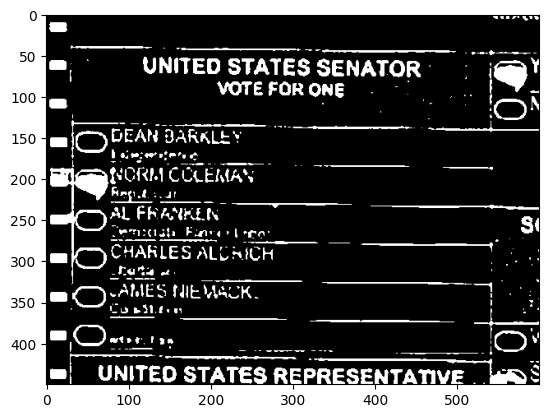

In [87]:
image_width = 600
image_height = 450

def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
    image = cv2.resize(image, (image_width, image_height))  # Resize images (example size, adjust as needed)
    _, image = cv2.threshold(image, 170, 255, cv2.THRESH_BINARY_INV)  # Thresholding for clarity
    return image

# Example: Loading a single image
image_path = './images/noballot_2.jpg'
ballot_image = load_and_preprocess_image(image_path)

plt.imshow(ballot_image, cmap='gray')
plt.show()

In [88]:
def extract_features(image):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image.flatten()

features = extract_features(ballot_image)
print(features)

[249 246 251 ... 252 253 252]


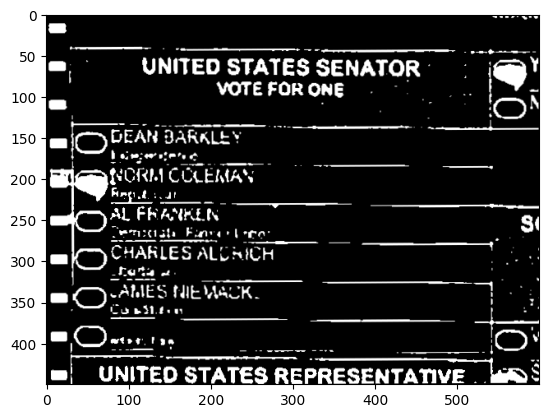

In [89]:
import random

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

rotated_image = rotate_image(ballot_image, random.random() * random.randint(-5, 5))

plt.imshow(rotated_image, cmap='gray')
plt.show()

In [105]:
num_augmented_copies = 5
dir = './images'
output_dir = os.path.join(dir, 'augmented')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def augment_images(image_path, num_copies, label):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    base_name = os.path.basename(image_path).split('.')[0]

    for i in range(num_copies):
        angle = random.uniform(-5, 5)
        new_image = rotate_image(image, angle)
        new_filename = f"{label}_{base_name}_var{i}.jpg"
        cv2.imwrite(os.path.join(output_dir, new_filename), new_image)

for i, filename in enumerate(os.listdir(dir)):
    if i < 2:
        if filename.endswith('.jpg'):
            image_path = os.path.join(dir, filename)
            augment_images(image_path, 1, 'not_duplicate')
    elif filename.endswith('.jpg'):
        image_path = os.path.join(dir, filename)
        augment_images(image_path, num_augmented_copies, 'duplicate')


In [106]:
from sklearn.model_selection import train_test_split
import glob

# Load images and labels
image_paths = glob.glob(f'{output_dir}/*.jpg')
labels = [1 if 'duplicate' in path else 0 for path in image_paths]  # 1 for duplicate, 0 for original

# Split the data
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [107]:
def process_images(file_paths, labels):
    images = []
    for file in file_paths:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))  # Resize to the input size of your model
        img = img / 255.0  # Normalize pixel values
        images.append(img)

    return np.array(images), np.array(labels)

train_images, train_labels = process_images(train_paths, train_labels)
val_images, val_labels = process_images(val_paths, val_labels)


In [108]:
ballot_images = os.listdir(dir)
# print(ballot_images)
all_features = [extract_features(os.path.join(dir, image)) for image in ballot_images]
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(all_features)
# print(all_features)

/Users/jedhelmers/Documents/Development/aiml/ballot_clustering/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jedhelmers/Documents/Development/aiml/ballot_clustering/venv/lib/python3.11/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),  # Note the change here
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


Epoch 1/10
1/1 [==============================] - 0s 277ms/step - loss: 0.6329 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+